# UTKFace
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

![](https://susanqq.github.io/UTKFace/icon/samples.png)

# 1. Data Exploration and Visualization and Feature Engineering
---

In [ ]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
tf.config.experimental.set_virtual_device_configuration(
    physical_devices[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# folder path
folder_path = './UTKFace'

In [ ]:
# some standard parameter

batch = 16

In [ ]:
print(os.listdir(folder_path)[0])
# print(os.listdir(folder_path)[10])

100_0_0_20170112213500903.jpg.chip.jpg


In [ ]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [ ]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [ ]:
df.head()

,age,gender,img
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [ ]:
df.shape

(23708, 3)

## Splitting the dataset 
------

In [ ]:
train_df = df[0:20000]
test_df = df[20000:]

In [ ]:
test_df.shape,train_df.shape

((3708, 3), (20000, 3))

## We have required data Now lets do data Augmentation and create a Pipeline
---

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   rotation_range = 30,
                                   height_shift_range =0.2,
                                   width_shift_range =0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


# Now creating the Model ( doing transfer learning here over ResNet50)
---

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *

In [ ]:
resnet = ResNet50(include_top= False, weights= 'imagenet',input_shape = (200,200,3))

In [ ]:
resnet.trainable=  False
output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [ ]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [ ]:
# Early stopping and Reduce learning rate if the model is not improving
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=0.00001)


In [ ]:
model.compile(optimizer = 'Adam', loss = {'age': 'mae', 'gender': 'binary_crossentropy'},  metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [ ]:
hist = model.fit(train_generator, epochs = 100, batch_size = 32, validation_data = test_generator, callbacks=[earlystop, learning_rate_reduction])

Epoch 1/50
625/625 [==============================] - 178s 279ms/step - loss: 96.3099 - age_loss: 11.3434 - gender_loss: 0.8582 - age_mae: 11.3434 - gender_accuracy: 0.5085 - val_loss: 105.4270 - val_age_loss: 37.0282 - val_gender_loss: 0.6909 - val_age_mae: 37.0282 - val_gender_accuracy: 0.5383 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 159s 254ms/step - loss: 79.8943 - age_loss: 10.9474 - gender_loss: 0.6964 - age_mae: 10.9474 - gender_accuracy: 0.5189 - val_loss: 104.5283 - val_age_loss: 36.1237 - val_gender_loss: 0.6910 - val_age_mae: 36.1237 - val_gender_accuracy: 0.5383 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 197s 314ms/step - loss: 79.7006 - age_loss: 10.8846 - gender_loss: 0.6951 - age_mae: 10.8846 - gender_accuracy: 0.5197 - val_loss: 103.7712 - val_age_loss: 35.3361 - val_gender_loss: 0.6913 - val_age_mae: 35.3361 - val_gender_accuracy: 0.5383 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 205s 328ms/step 

In [ ]:
model.save("age_gen_ver_2.h5")

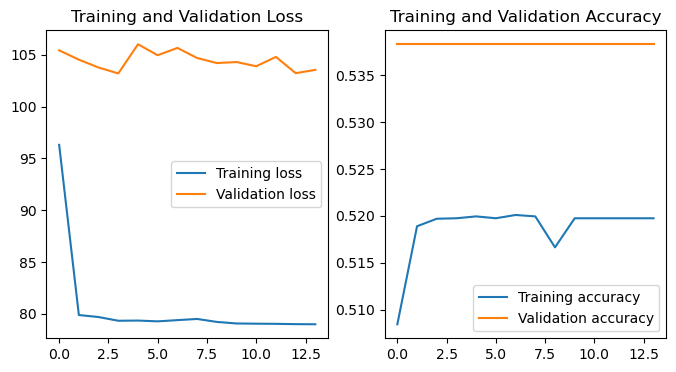

In [ ]:
# plotting the loss and accuracy
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(hist.history['loss'], label='Training Loss')
# plt.plot(hist.history['val_loss'], label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')

hist.history.keys()
# dict_keys(['loss', 'age_loss', 'gender_loss', 'age_mae', 'gender_accuracy', 'val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_mae', 'val_gender_accuracy', 'lr'])
# these are the keys of the dictionary hist.history, plot every key to see the graph



plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training loss')

plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['gender_accuracy'], label='Training accuracy')
plt.plot(hist.history['val_gender_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()



# predicting using the model on Test data
---

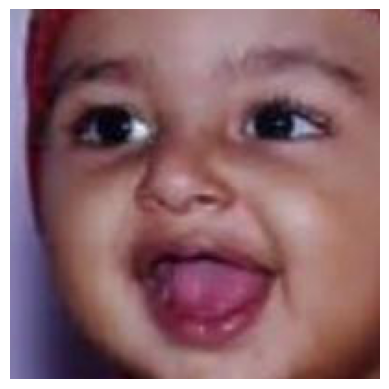

In [ ]:
test_img = "UTKFace/1_0_3_20161219230303992.jpg.chip.jpg"
img = plt.imread(test_img)
plt.axis('off')
plt.imshow(img)

In [ ]:
pred = model.predict(np.expand_dims(img,axis=0))

1/1 [==============================] - 0s 43ms/step


In [ ]:
gen = pred[1]
# gen = int(np.round(gen))

gen= int(gen)
gender = lambda gen: 'male' if gen < 0.5 else 'female'
gender(gen)
# gender


'male'

1/1 [==============================] - 0s 25ms/step


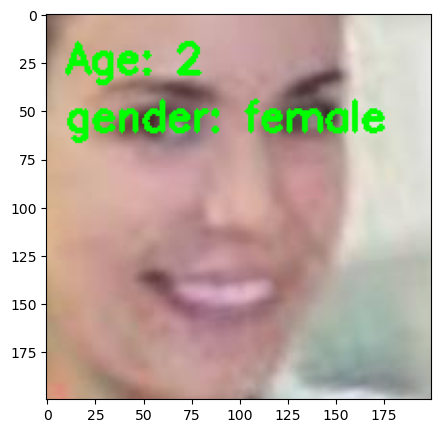

1/1 [==============================] - 0s 25ms/step


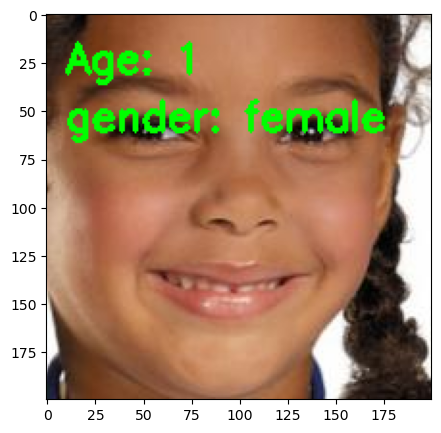

1/1 [==============================] - 0s 27ms/step


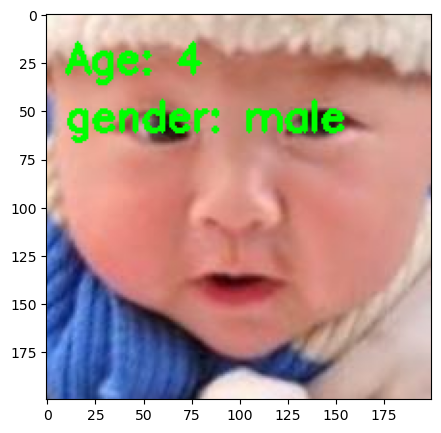

1/1 [==============================] - 0s 38ms/step


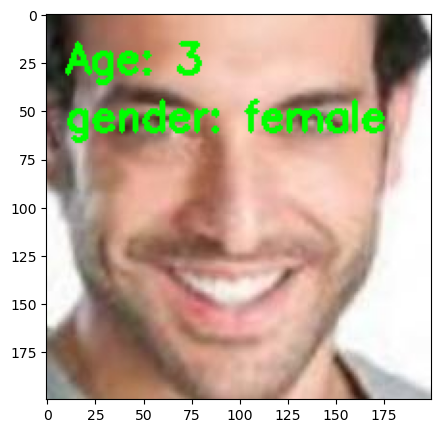

1/1 [==============================] - 0s 28ms/step


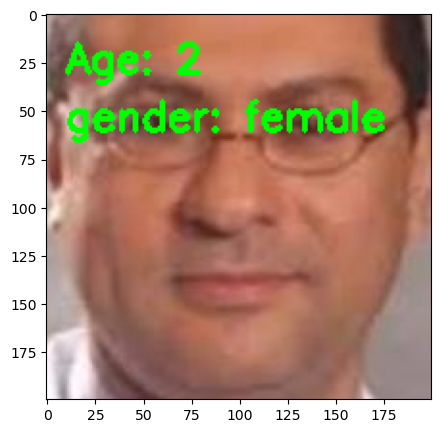

1/1 [==============================] - 0s 27ms/step


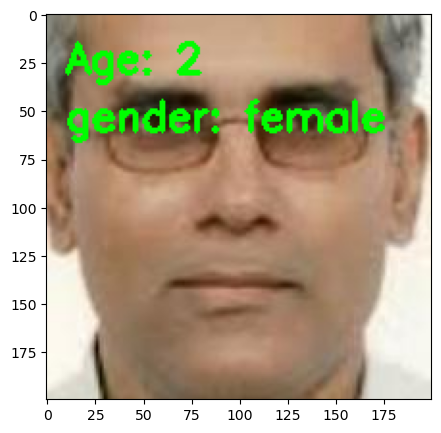

1/1 [==============================] - 0s 28ms/step


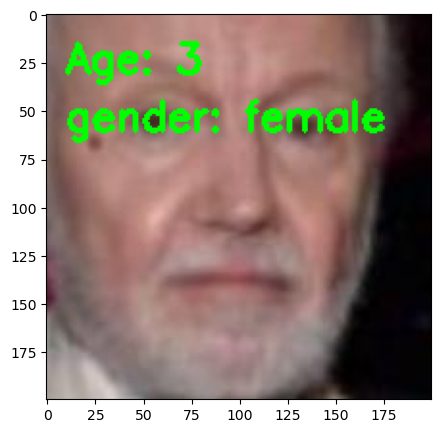

1/1 [==============================] - 0s 28ms/step


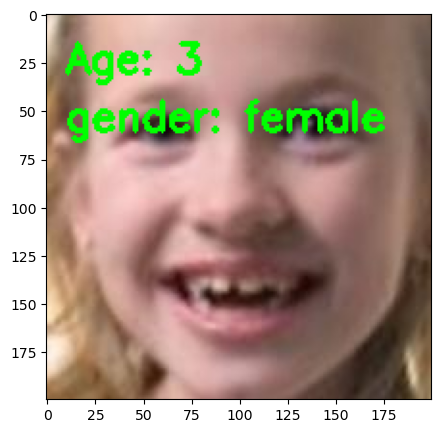

1/1 [==============================] - 0s 24ms/step


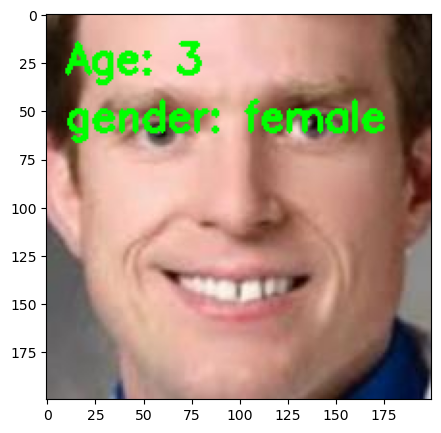

1/1 [==============================] - 0s 29ms/step


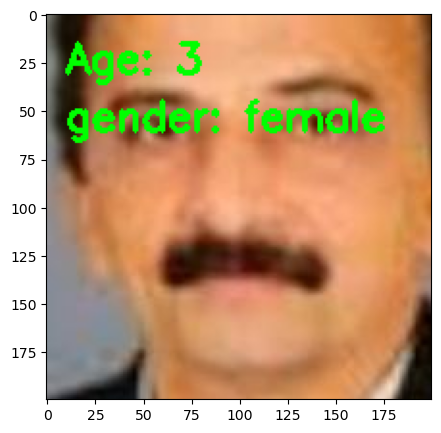

In [ ]:
# Randomly picking 10 images from UTKFace and predicting upon
import random
import cv2
import matplotlib.pyplot as plt

path = "UTKFace/"
files = os.listdir(path)
random.shuffle(files)
files = files[:10]

for file in files:
    plt.figure(figsize=(5,5))
    img = cv2.imread(path+file)
    pred = model.predict(np.expand_dims(img,axis=0))
    age = int(pred[0][0])
    gen = pred[1]
    gender = lambda gen: 'male' if gen < 0.5 else 'female' # the value lies between 0 and 1
    gender= gender(gen)

    # write age and gender on the image

    img = cv2.putText(img, "Age: "+str(int(pred[0][0])), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    img = cv2.putText(img, "gender: "+ str(gender), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    # convert to rgb
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.imshow(
    plt.show()

